In [32]:
import pandas as pd
import seaborn as sns

## Load and format the temperature anomaly data

In [33]:
PATH_RAW_TEMP_DATA_FOLDER = 'data/raw/temperature/'
PATH_PROCESSED_TEMP_DATA_FOLDER = 'data/processed/temperature/'
PATH_COUNTRIES_LAND_FOLDER = 'countries-land/'
PATH_REGIONS_LAND_FOLDER = 'regions-land/'

In [34]:
PATH_COUNTRIES_LIST_FILE = 'temp-countries-list.csv'
PATH_UN_COUNTRY_CODES_FILE = 'data/raw/country-codes/un-country-codes.csv'
PATH_GLOBAL_LAND_OCEAN_FILE = 'global-land-ocean.txt'

In [35]:
# Todo: remove loading temp_countries from processed data when combining jupyter notebooks
temp_countries: pd.DataFrame = pd.read_csv(PATH_PROCESSED_TEMP_DATA_FOLDER + PATH_COUNTRIES_LIST_FILE, sep=',')

### Load temp-land-country data

In this section we load Berkleys land-temperature data for each country from the corresponding .txt files and combine them into a single dataframe. We also change the naming of the countries according to the naming standard of the UN and add their ISO3-Country code.

In [36]:
temp_land_country_column_names = ["country_code", "country_name", "year", "month", "monthly_anomaly", "monthly_unc", "annual_anomaly",
                                  "annual_unc", "five_year_anomaly", "five_year_unc", "ten_year_anomaly", "ten_year_unc", "twenty_year_anomaly", "twenty_year_unc"]

temp_land_country = pd.DataFrame(columns=temp_land_country_column_names)

temp_country_names = temp_countries['Country']

# Todo when combining use the dictionary in the data-integration notebook
new_country_names = {
    "Denmark (Europe)": "Denmark",
    "France (Europe)": "France",
    "Netherlands (Europe)": "Netherlands",
    "United Kingdom (Europe)": "United Kingdom",
    "Åland": "Åland Islands",
    "Czech Republic": "Czechia",
    "Turkey": "Türkiye",
    "Svalbard and Jan Mayen": "Svalbard and Jan Mayen Islands",
    "Cape Verde": "Cabo Verde",
    "Turks and Caicas Islands": "Turks and Caicos Islands",
    "Swaziland": "Eswatini",
    "Macedonia": "North Macedonia",
    "Côte d'Ivoire": "Côte d’Ivoire",
    "Federated States of Micronesia": "Micronesia (Federated States of)",
    "South Georgia and the South Sandwich Isla": "South Georgia and the South Sandwich Islands",
    "Bonaire, Saint Eustatius and Saba": "Bonaire, Sint Eustatius and Saba",
    "Congo (Democratic Republic of the)": "Democratic Republic of the Congo",
    "South Korea": "Korea, South",
    "North Korea": "Korea, North",
    "Palestina": "State of Palestine"
}

def swap_keys_values(d):
    return {v: k for k, v in d.items()}

map_country_to_filename = swap_keys_values(new_country_names)

for temp_country_name in temp_country_names:
    temp_country_file_name = temp_country_name
    if temp_country_name in map_country_to_filename:
        temp_country_file_name = map_country_to_filename[temp_country_name]
    path_temp_country_txt_file = PATH_RAW_TEMP_DATA_FOLDER + PATH_COUNTRIES_LAND_FOLDER + temp_country_file_name + '.txt'
    temp_land_one_country = pd.read_csv(path_temp_country_txt_file, comment="%", header=None, delim_whitespace=True)
    country_iso_name = temp_countries.loc[temp_countries['Country'] == temp_country_name]['ISO-alpha3'].iloc[0]

    temp_land_one_country.insert(0, 'country_code', country_iso_name)
    temp_land_one_country.insert(1, 'country_name', temp_country_name)

    temp_land_one_country.columns=temp_land_country_column_names

    temp_land_country = pd.concat([temp_land_country, temp_land_one_country])

temp_land_country.head()

,country_code,country_name,year,month,monthly_anomaly,monthly_unc,annual_anomaly,annual_unc,five_year_anomaly,five_year_unc,ten_year_anomaly,ten_year_unc,twenty_year_anomaly,twenty_year_unc
0,AFG,Afghanistan,1848,5,-0.297,2.037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AFG,Afghanistan,1848,6,-0.796,2.136,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AFG,Afghanistan,1848,7,-0.113,1.937,-0.777,0.639,NaN,NaN,NaN,NaN,NaN,NaN
3,AFG,Afghanistan,1848,8,-0.462,1.937,-0.743,0.644,NaN,NaN,NaN,NaN,NaN,NaN
4,AFG,Afghanistan,1848,9,-1.272,1.865,-0.676,0.669,NaN,NaN,NaN,NaN,NaN,NaN


### Create temp-land-region data from temp-land-country data

Berkleys offers a dataset with regional temperature anomly data, however because we also use datasets for natural disasters and population we have to ensure that regions in all datasets are including the same countries. The regions defined for Berkleys regional temp anomaly datasets differ from the definition of regions in the UN dataset we use, therefore we decided to calculate regional temp anomalies based on the berkleys temp anomaly data for individual countries for regions based on the region data of the UN dataset.

Temperature anomalies tend to be similar across large regions geographical regions, even if the absolute temperature of two different measuring points differs for the same time period, their anomalies tend to be quite similar. To create regional temperature anomaly data we calculate the mean of temperature anomaly measures for all countries in a given region on a monthly basis. Source: https://data.giss.nasa.gov/gistemp/faq/#q101

When computing a region it is possible that some countries are not included, because it is possible that countries started reporting earlier than others or stopped reporting for some time periods.

In [37]:
def calc_region_anomaly(temp_land_country_regions):
    temp_return_land_region = temp_land_country_regions.groupby(['region_code', 'region_name', 'year', 'month'], as_index=False)['monthly_anomaly'].mean()
    temp_return_land_region.rename({ 'monthly_anomaly': 'temperature_anomaly'}, axis=1,inplace=True)
    return temp_return_land_region

In [38]:
# Todo: only load UN country codes once after combining notebook
# load and format un-country-codes data
un_country_codes = pd.read_csv(PATH_UN_COUNTRY_CODES_FILE, sep=";")
un_country_codes = un_country_codes[['Region Code', 'Region Name', 'ISO-alpha3 Code']]
un_country_codes.columns=['region_code', 'region_name', 'country_code']

# Join UN country codes to temp data
# exclude temp data for antarctica when calculating regional temp data
temp_land_country_no_antarctica = temp_land_country[temp_land_country.country_name != 'Antarctica']
temp_land_country_regions = pd.merge(temp_land_country_no_antarctica, un_country_codes, on='country_code', how='left')
temp_land_country_regions.loc[temp_land_country_regions['country_name']=='Taiwan','region_name'] = 'Asia'
temp_land_country_regions.loc[temp_land_country_regions['country_name']=='Taiwan','region_code'] = 142

# calculate anomaly data for regions
temp_land_region = calc_region_anomaly(temp_land_country_regions)

temp_land_region.head()

,region_code,region_name,year,month,temperature_anomaly
0,2.0,Africa,1787,1,0.1520
1,2.0,Africa,1787,2,-0.3142
2,2.0,Africa,1787,3,-0.7876
3,2.0,Africa,1787,4,-0.9146
4,2.0,Africa,1787,5,-0.5570


Load berkleys regional data

We load Berkleys regional temperature anomaly data to compare it to the regional temperature anomaly data we calculated from the country temperature anomaly data and UN regions combined.

We combine Berkleys North and South America region to one Region 'Americas' to be able to compare it to the combined 'Americas' region of the UN data later.

In [39]:
# Todo: make this code segment prettier; reuse other code segments

temp_land_country_column_names = ["region_name", "year", "month", "monthly_anomaly", "monthly_unc", "annual_anomaly", "annual_unc", "five_year_anomaly", "five_year_unc", "ten_year_anomaly", "ten_year_unc", "twenty_year_anomaly", "twenty_year_unc"]
temp_berkley_regions = ['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America']
temp_berkleys_land_region = pd.DataFrame(columns=temp_land_country_column_names)

for temp_berkley_region in temp_berkley_regions:
    region_file_name = temp_berkley_region
    path = PATH_RAW_TEMP_DATA_FOLDER + PATH_REGIONS_LAND_FOLDER + region_file_name + '.txt'
    one_region = pd.read_csv(path, comment="%", header=None, delim_whitespace=True)
    one_region.insert(0, 'region_name', temp_berkley_region)
    one_region.columns=temp_land_country_column_names
    temp_berkleys_land_region = pd.concat([temp_berkleys_land_region, one_region])

temp_berkleys_land_region.loc[(temp_berkleys_land_region['region_name'] == 'South America') | (temp_berkleys_land_region['region_name'] == 'North America'), 'region_name'] = 'Americas'
temp_berkleys_land_region = temp_berkleys_land_region[['region_name', 'year', 'month', 'monthly_anomaly']]
temp_berkleys_land_region = temp_berkleys_land_region.groupby(by=['region_name', 'year', 'month'])['monthly_anomaly'].mean()
temp_berkleys_land_region = temp_berkleys_land_region.reset_index()
temp_berkleys_land_region = temp_berkleys_land_region.rename(columns={'monthly_anomaly': 'temperature_anomaly'})

temp_berkleys_land_region.head()

,region_name,year,month,temperature_anomaly
0,Africa,1880,8,-0.181
1,Africa,1880,9,-0.389
2,Africa,1880,10,-0.274
3,Africa,1880,11,-0.169
4,Africa,1880,12,-0.396


### Load temp-land-ocean-global data

Two versions exist that treat temperature anomalies at locations with sea ice:
1. Anomalies are extrapolated from land-surface air temperature anomalies.
2. Anomalies are extrapolated from sea-surface water temperature anomalies (usually collected from open water areas on the periphery of the sea ice).

We choose to use the air temperature version based on Berkleys remark:
"We believe that the use of air temperatures above sea ice provides a more natural means of describing changes in Earth's surface temperature."

In [40]:
# only include the dataset where anomalies are extrapolated from land-surface air temperature anomalies.
temp_land_ocean_global = pd.read_csv(PATH_RAW_TEMP_DATA_FOLDER + PATH_GLOBAL_LAND_OCEAN_FILE, comment="%", header=None, delim_whitespace=True, engine='python', skipfooter=2079)
temp_land_ocean_global.columns = ["year", "month", "monthly_anomaly", "monthly_unc", "annual_anomaly", "annual_unc", "five_year_anomaly", "five_year_unc", "ten_year_anomaly", "ten_year_unc", "twenty_year_anomaly", "twenty_year_unc"]
temp_land_ocean_global.head()

,year,month,monthly_anomaly,monthly_unc,annual_anomaly,annual_unc,five_year_anomaly,five_year_unc,ten_year_anomaly,ten_year_unc,twenty_year_anomaly,twenty_year_unc
0,1850,1,-0.736,0.389,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1850,2,-0.202,0.526,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1850,3,-0.363,0.333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1850,4,-0.589,0.334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1850,5,-0.614,0.217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Format the data

We only keep entries after the year 1900 because our research questions focus on the past 100 years.

In [41]:
def cut_before_1900(temp_data):
    return temp_data[temp_data['year'] >= 1900]

We only keep monthly anomaly data and rename the column to temperature_anomaly

In [42]:
def keep_monthly_anomalies(temp_data):
    drop_labels = ["monthly_unc", "annual_anomaly", "annual_unc", "five_year_anomaly", "five_year_unc", "ten_year_anomaly", "ten_year_unc", "twenty_year_anomaly", "twenty_year_unc"]
    temp_data = temp_data.drop(labels=drop_labels, axis=1)
    return temp_data.rename(columns={'monthly_anomaly': 'temperature_anomaly'})

#### Format temp-land-country

In [43]:
temp_land_country = cut_before_1900(temp_land_country)
temp_land_country = keep_monthly_anomalies(temp_land_country)

#### Format temp-land-region and berkleys regional data

In [44]:
temp_land_region = cut_before_1900(temp_land_region)
temp_berkleys_land_region = cut_before_1900(temp_berkleys_land_region)

#### Format temp-land-ocean-global

In [45]:
temp_land_ocean_global = cut_before_1900(temp_land_ocean_global)
temp_land_ocean_global = keep_monthly_anomalies(temp_land_ocean_global)

#### Compare berkleys and our regional data

In [46]:
def temp_calc_region_corr(temp_single_region):
    temp_land_single_region = temp_land_region[(temp_land_region['region_name'] == temp_single_region)].set_index(['year', 'month'])
    temp_berkleys_land_single_region = temp_berkleys_land_region[(temp_berkleys_land_region['region_name'] == temp_single_region)].set_index(['year', 'month'])

    comp_temp_land_africa_joined = temp_berkleys_land_single_region.join(temp_land_single_region, on=['year', 'month'], lsuffix='_berkleys', rsuffix='_self')

    temp_land_region_corr = comp_temp_land_africa_joined['temperature_anomaly_berkleys'].corr(comp_temp_land_africa_joined['temperature_anomaly_self'])

    print('Correlation for region ' + temp_single_region + ' ' + str(temp_land_region_corr))

Correlation of temperature anomalies between our and berkleys regional temp data sets

In [47]:
temp_berkley_regions = ['Africa', 'Asia', 'Europe', 'Americas', 'Oceania']

for temp_berkley_region in temp_berkley_regions:
    temp_calc_region_corr(temp_berkley_region)

Correlation for region Africa 0.9706252186825862
Correlation for region Asia 0.6557149670319498
Correlation for region Europe 0.9850257827303103
Correlation for region Americas 0.7693620438292185
Correlation for region Oceania 0.5959564544896369


## Check all temperature_anomaly columns for NaN values

In [48]:
print(temp_land_country['temperature_anomaly'].isna().sum())
print(temp_land_region['temperature_anomaly'].isna().sum())
print(temp_land_ocean_global['temperature_anomaly'].isna().sum())

205
0
0


## Handle NaN values in temp_land_country

In [49]:
temp_land_country[temp_land_country['temperature_anomaly'].isna()].groupby('country_code').size()

country_code
ALA     1
BLM     1
CIV     1
CUW     1
ECU     8
FJI     3
FSM     6
GUM    41
KIR    75
PLW     6
PNG    30
PYF     7
SGS     1
SLB    24
dtype: int64

In [56]:
temp_country_kir = temp_land_country[temp_land_country['country_code']=='KIR']
temp_country_kir[temp_country_kir['temperature_anomaly'].isna()==True].tail()

,country_code,country_name,year,month,temperature_anomaly
1454,KIR,Kiribati,2012,3,NaN
1455,KIR,Kiribati,2012,4,NaN
1468,KIR,Kiribati,2013,5,NaN
1558,KIR,Kiribati,2020,11,NaN
1559,KIR,Kiribati,2020,12,NaN


1452


<AxesSubplot: ylabel='temperature_anomaly'>

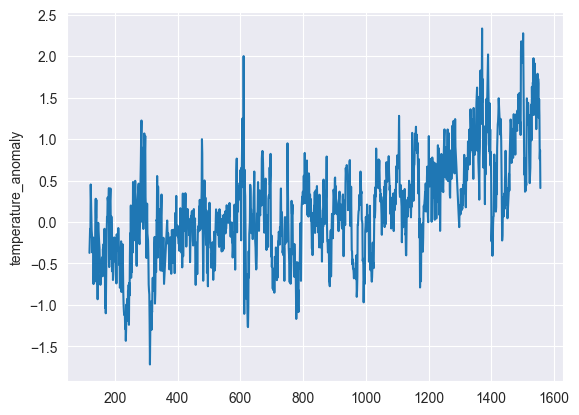

In [54]:
print(temp_country_kir['temperature_anomaly'].size)
sns.lineplot(temp_country_kir['temperature_anomaly'])

### Save the data as csv files

In [51]:
temp_land_country.to_csv(PATH_PROCESSED_TEMP_DATA_FOLDER + 'temp-land-country.csv', index=False)
temp_land_region.to_csv(PATH_PROCESSED_TEMP_DATA_FOLDER + 'temp-land-region.csv', index=False)
temp_land_ocean_global.to_csv(PATH_PROCESSED_TEMP_DATA_FOLDER + 'temp-land-ocean-global.csv', index=False)